# Instacart dataset EDA 프로젝트

<img src="instacartl2.png" alt="Drawing" style="width: 1000px"/>
<img src="instacart1.jpg" alt="Drawing" style="width: 500px"/>


In [1]:
from IPython.display import Image

# 회사 개요
- **"식품계의 우버"라 불리는 미국의 신선식품 배달 서비스 스타트업. (ex : 한국의 B마트)**
- **월마트, 세이프웨이, 코스트코등 대형마트 부터 지역 슈퍼마켓**
- **설립 2년 만에 유니콘**
- **8년간 16억달러(약 1조8800억원) 투자유치**

# Dataset 개요
> - **총 유저수 : 206,209(약 20만 명)**
> - **판매된 총 제품수 : 33,819,106(약 3380만 건)**
> - **품목 수 : 49,688(약 5만 종)**
> - **총 주문량 : 3,421,083(약 340만 건)**
> - **품목당 평균 판매 횟수 : 약 680건**
> - **유저 1명당 평균 주문 횟수 : 16.5회**
> - **재구매율 : 약 59%**

## 선택한 이유 :
> - **데이터의 양**
> - **실제 생활과 밀접**
> - **예측 모델**

## 데이터 로드

In [170]:
df_orders = pd.read_csv("data/orders.csv")
df_order_products = pd.read_csv("data/order_products.csv")
df_ptoducts = pd.read_csv("data/products.csv")
df_aisles = pd.read_csv("data/aisles.csv")
df_departments = pd.read_csv("data/departments.csv")
product_plus_aisle = pd.merge(df_ptoducts, df_aisles)
product_plus_aisle_plus_departments = pd.merge(
    product_plus_aisle, df_departments)
product_plus_aisle_plus_departments_plus_order_products = pd.merge(
    product_plus_aisle_plus_departments, df_order_products)
raw_data = pd.merge(
    product_plus_aisle_plus_departments_plus_order_products, df_orders)

##  raw_data 컬럼

### 시간관련
- order_dow: 주문한 요일
- order_hour_of_day: 주문한 시간


### 제품관련
- product_id: 제품 ID
- product_name: 제품 이름
- aisle_id: 소분류 ID
- aisle: 소분류 이름
- department_id: 대분류 ID
- department: 대분류 이름


### 주문관련
- user_id: 고객 ID
- order_id: 주문 ID
- add_to_cart_order: 각 제품이 장바구니에 추가 된 순서
- reordered: 사용자가 해당 제품을 과거에 주문한 경우 1, 그렇지 않으면 0

### etc
- days_since_prior: 마지막 주문 이후 일 수, 30 일 제한 (NA는 order_number1) 재주문 기간의 텀
- aisle_id : foreign key
- department_id: foreign key
- eval_set: 이 순서가 속하는 평가 세트
- order_number: 이 사용자의 주문 순서 번호 (1 = 첫 번째, n = n 번째)

# 그래서 뭐가 궁금한가?

# 이용자들은 어떤 물건을 재구매할 확률이 높은 걸까?

## 가설 1 : 시간 및 요일등에 따라 품목과 재구매 정도의 차이가 있을것이다.
## 가설 2 :  판매량이 높은 제품이 재구매도 많을 것이다.
## 가설 3 : 장바구니의 첫번째 담은 물건의 재구매의 확률이 높을 것이다.

## 시간 및 요일별 구매 및 재구매 횟수

In [6]:
# 시간,요일 별 구매 횟수
df = pd.pivot_table(raw_data, index=raw_data['order_dow'],
                    columns=raw_data['order_hour_of_day'], aggfunc='count', values='user_id')
df = df / 1000
df = df.astype("int")

# 시간,주 별 재구매 횟수
columns = [	'reordered', 'order_dow', 'order_hour_of_day']
data_time = raw_data[columns]
time_table = data_time.pivot_table(
    index='order_dow', columns='order_hour_of_day',
    values='reordered', aggfunc=sum)

time_table = time_table / 1000
time_table = time_table.astype("int")

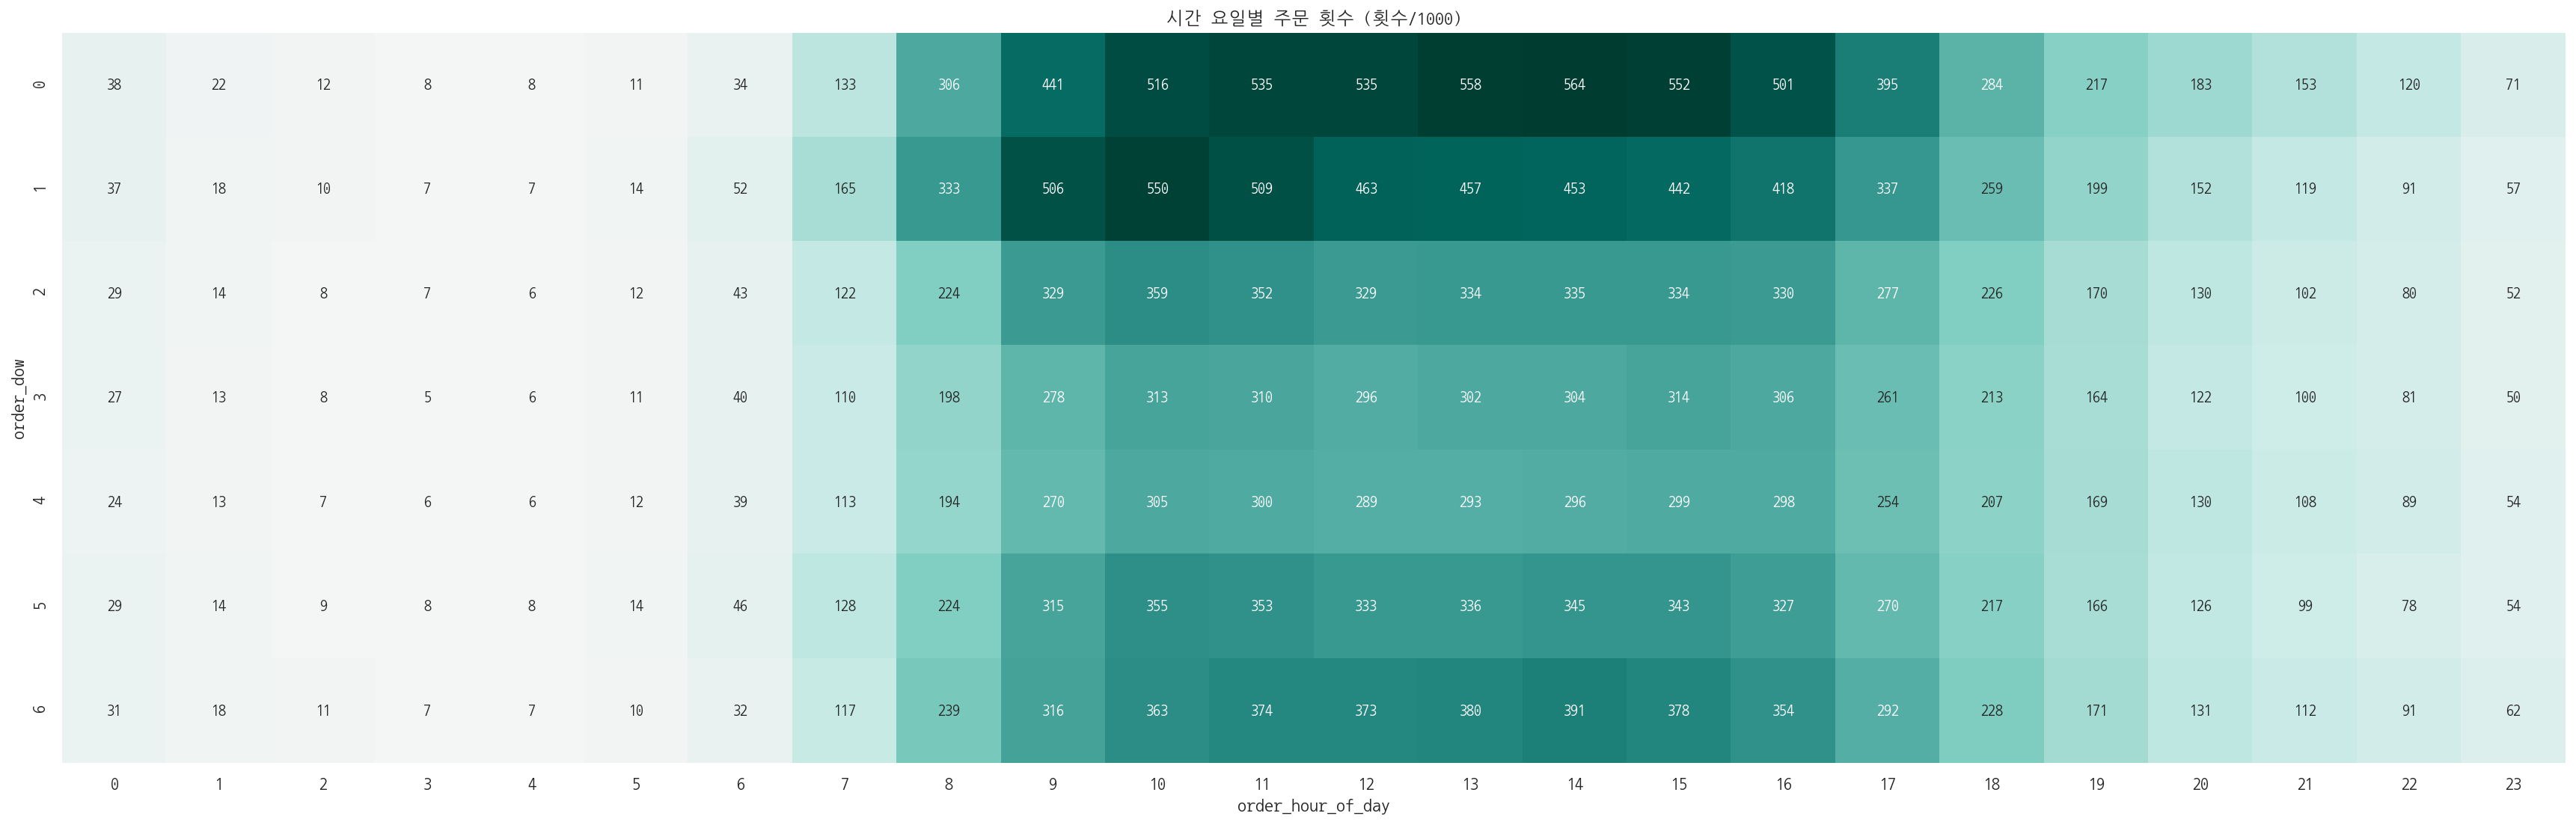

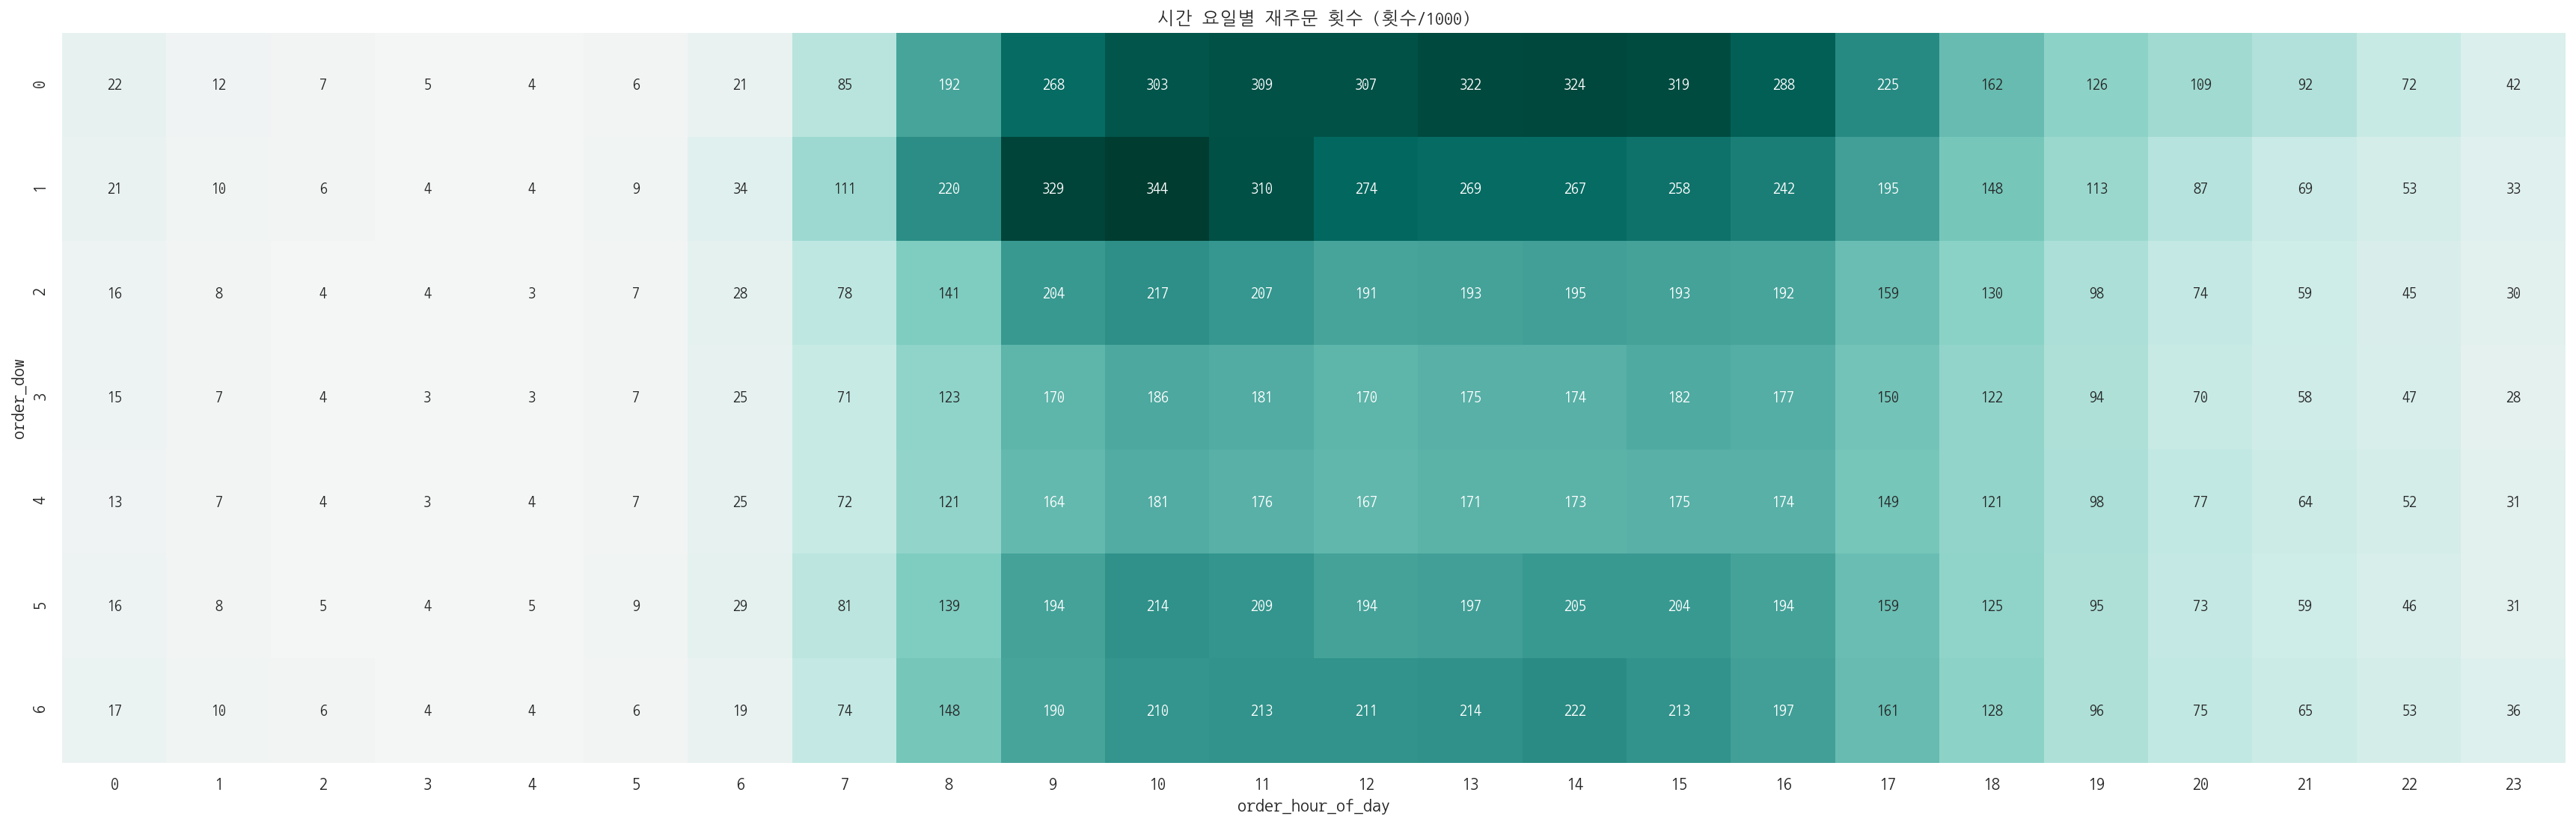

In [279]:
%matplotlib inline
plt.figure(figsize=(24, 8))
plt.subplot(121)
ax = plt.axes()
ax.set_title('시간 요일별 주문 횟수 (횟수/1000)')
sns.heatmap(df, cmap="BrBG", center=3, annot=True,
            fmt="d", square=True, cbar=False, ax=ax)
plt.tight_layout()

plt.figure(figsize=(24, 8))
plt.subplot(122)
ax = plt.axes()
ax.set_title('시간 요일별 재주문 횟수 (횟수/1000)')
sns.heatmap(time_table, cmap="BrBG", center=3, annot=True,
            fmt="d", square=True, cbar=False, ax=ax)
plt.tight_layout()
plt.show()

- ### 09시 ~ 17시 사이에 주문이 집중
- ### 토,일요일에 주문이 집중(0,1)
- ### 시간, 요일에 따른 구매횟수와 재주문 횟수는 비슷한 빈도를 보임


### 구매가 가장 많이 일어나는 시간대에 무슨 품목이 많이 팔리는가?

In [13]:
# 토요일, 일요일 별 구매 상품 순위
daily_product = pd.pivot_table(
    raw_data, index=raw_data['product_name'], columns=raw_data['order_dow'], aggfunc='count', values='user_id')

result = []
for i in range(0, 2):
    a = daily_product[i].sort_values(ascending=False)[:10].index
    result.append(a)

daily_product = pd.DataFrame(result)
daily_product['order_dow'] = [0, 1]
daily_product.set_index('order_dow')

,0,1,2,3,4,5,6,7,8,9
order_dow,,,,,,,,,,
0,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries
1,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Organic Raspberries,Organic Whole Milk


In [24]:
raw_data01 = raw_data.copy()
for i in range(2,7):
    raw_data01 = raw_data01[raw_data01['order_dow'] != i]

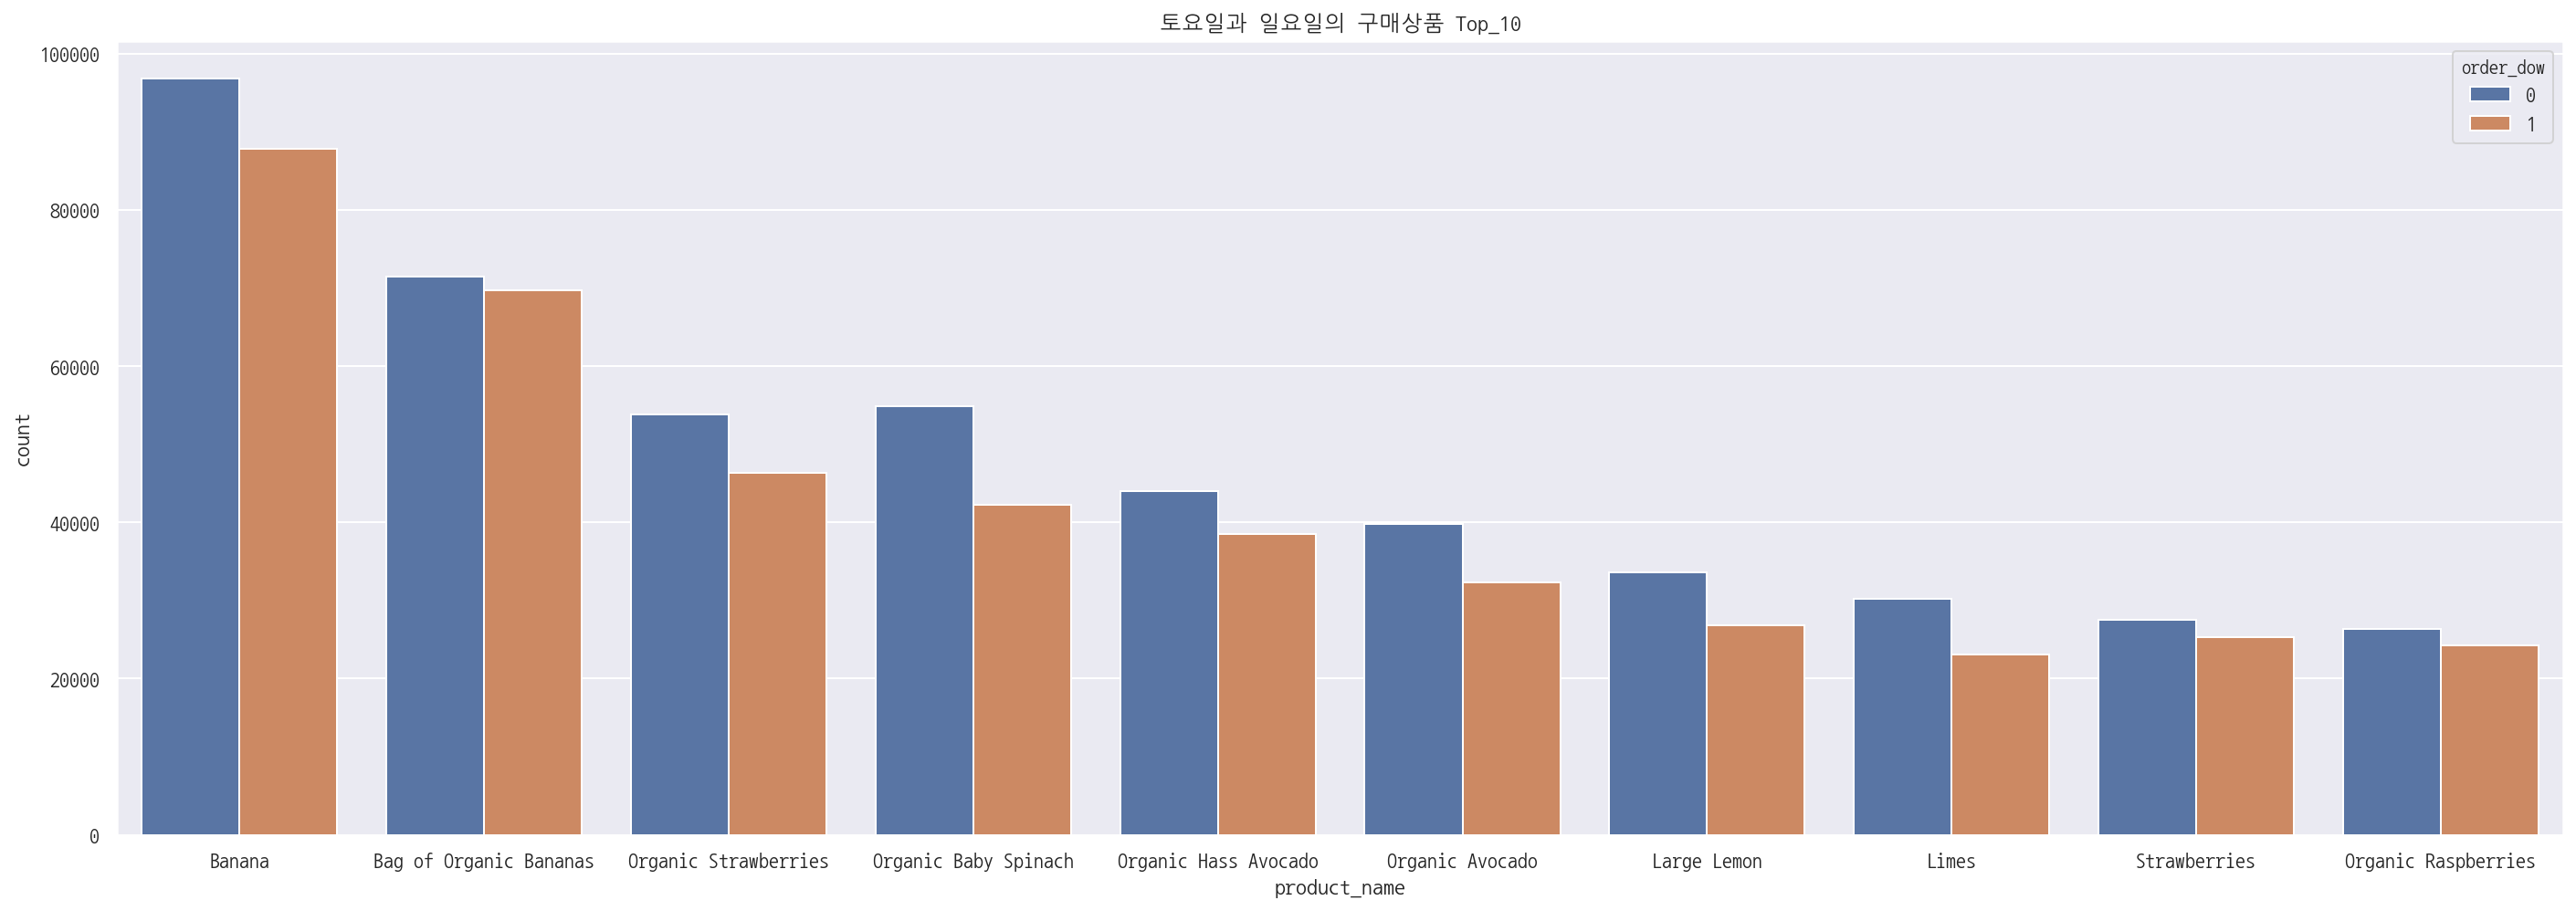

In [276]:
plt.figure(figsize=(24,8))
sns.countplot(raw_data01['product_name'], hue=raw_data01['order_dow'], order= raw_data01['product_name'].value_counts()[:10].index)
plt.title('토요일과 일요일의 구매상품 Top_10')
plt.show()

In [332]:
# 시간대 별(9시 ~ 16시까지) 구매 상품 순위
df = pd.pivot_table(raw_data, index=raw_data['product_name'],
                    columns=raw_data['order_hour_of_day'], aggfunc='count', values='user_id')
result = []
for i in range(9, 17):
    a = df[i].sort_values(ascending=False)[:10].index
    result.append(a)
hourly_product = pd.DataFrame(result)
hourly_product['hour'] = [9, 10, 11, 12, 13, 14, 15, 16]
hourly_product.set_index('hour')
hourly_product

,0,1,2,3,4,5,6,7,8,9,hour
0,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Strawberries,Large Lemon,Organic Raspberries,Organic Whole Milk,9
1,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Limes,Organic Raspberries,10
2,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries,11
3,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries,12
4,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,13
5,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,14
6,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,15
7,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries,16


In [51]:
raw_data_hour = raw_data.copy()
for i in range(0,9):
    raw_data_hour = raw_data_hour[raw_data_hour['order_hour_of_day'] != i]
for i in range(17,24):
    raw_data_hour = raw_data_hour[raw_data_hour['order_hour_of_day'] != i]

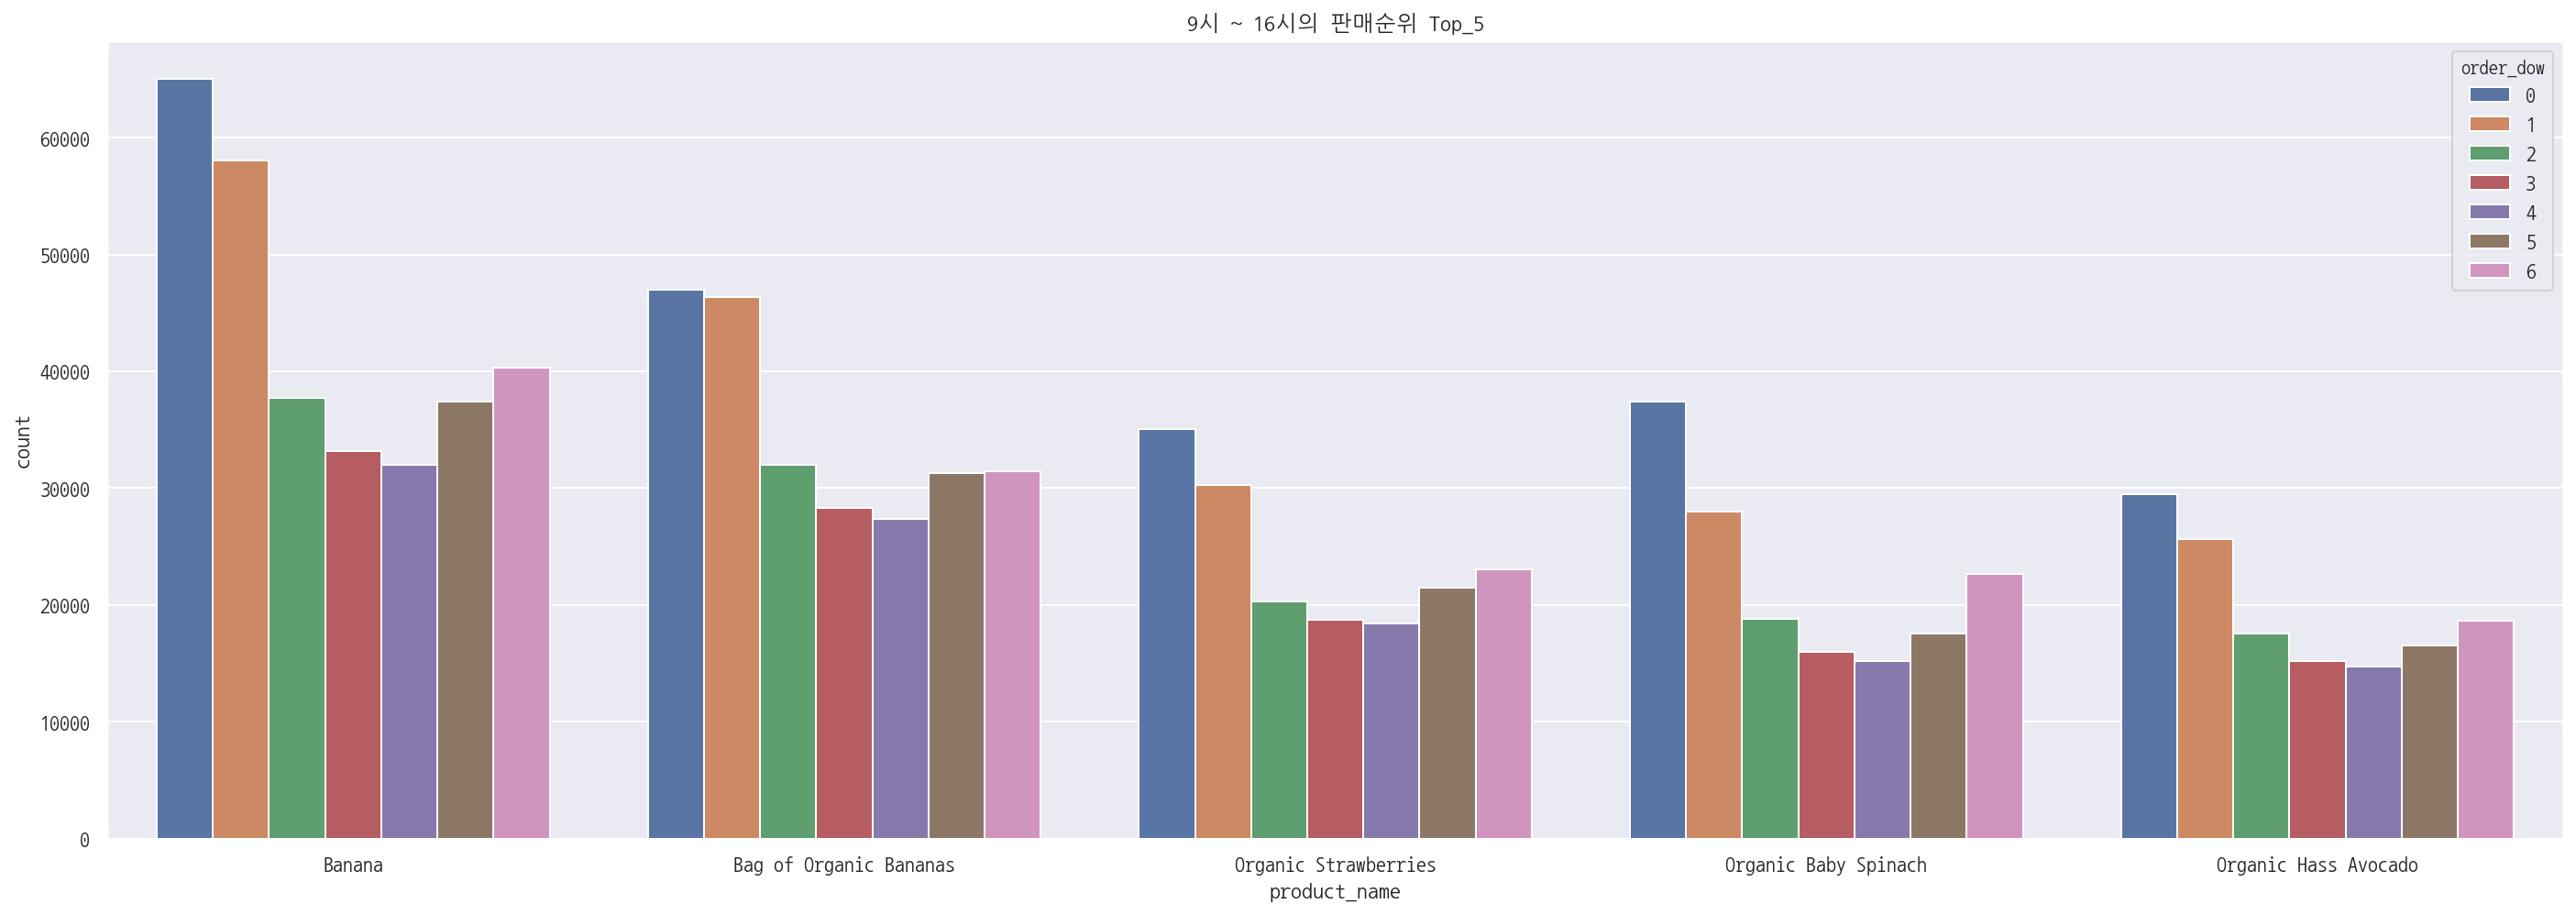

In [280]:
plt.figure(figsize=(24,8))
sns.countplot(raw_data_hour['product_name'], hue=raw_data_hour['order_dow'], order= raw_data_hour['product_name'].value_counts()[:5].index)
plt.title('9시 ~ 16시의 판매순위 Top_5')
plt.show()

# 가설 1의 결론:

- ### 토,일요일 낮시간대 (09~17시) 에 바나나(유기농), 딸기, 시금치, 아보카도 등이 많이 팔린다
- ### 요일, 시간별 구매횟수와 재구매 횟수는 비슷한 분포를 보인다.

## 가설 2 :  판매량이 높은 제품이 재구매도 많을 것이다.

## product

In [151]:
# 분석용 데이터 생성
columns = ['product_id', 'reordered', 'product_name']
data_product = raw_data[columns]

# 피봇테이블
product_table = data_product.pivot_table(
    index='product_name', columns='reordered', aggfunc='count', fill_value=0)
columns = ['first_order', 'reorder']
product_table.columns = columns

# 테이블 정리
product_table['product_total'] = product_table['first_order'] + \
    product_table['reorder']
product_table['product_reorder_rate'] = product_table['reorder'] / \
    product_table['product_total'] * 100
product_table.sort_values(by='product_total', ascending=False, inplace=True)
product_table.head()

,first_order,reorder,product_total,product_reorder_rate
product_name,,,,
Banana,73956,398609,472565,84.350089
Bag of Organic Bananas,63537,315913,379450,83.255501
Organic Strawberries,58838,205845,264683,77.770389
Organic Baby Spinach,55037,186884,241921,77.250011
Organic Hass Avocado,43453,170131,213584,79.655311


In [152]:
# 몇개 이상의 제품이 팔려야 많이 팔린것인가?
def numoforder(n):
     return product_table[product_table['product_total'] >= n]
n = 1000
print("{}개 이상 팔린 제품의 총 개수:".format(n),numoforder(n)['product_total'].sum())
print("총 팔린 제품의 개수:",product_table['product_total'].sum())
print(f'{n}개 이상 팔리면 전체 품목에서',round(numoforder(n)['product_total'].sum() / product_table['product_total'].sum() * 100,2),'%를 차지합니다.' )

1000개 이상 팔린 제품의 총 개수: 26503548
총 팔린 제품의 개수: 32434489
1000개 이상 팔리면 전체 품목에서 81.71 %를 차지합니다.


In [153]:
A = product_table[product_table['product_total'] >= 1000]['product_total'].sum()
B = product_table[product_table['product_total'] < 1000]['product_total'].sum()
labels = ['1000개 이상 팔린 제품', '1000개 미만 팔린 제품']

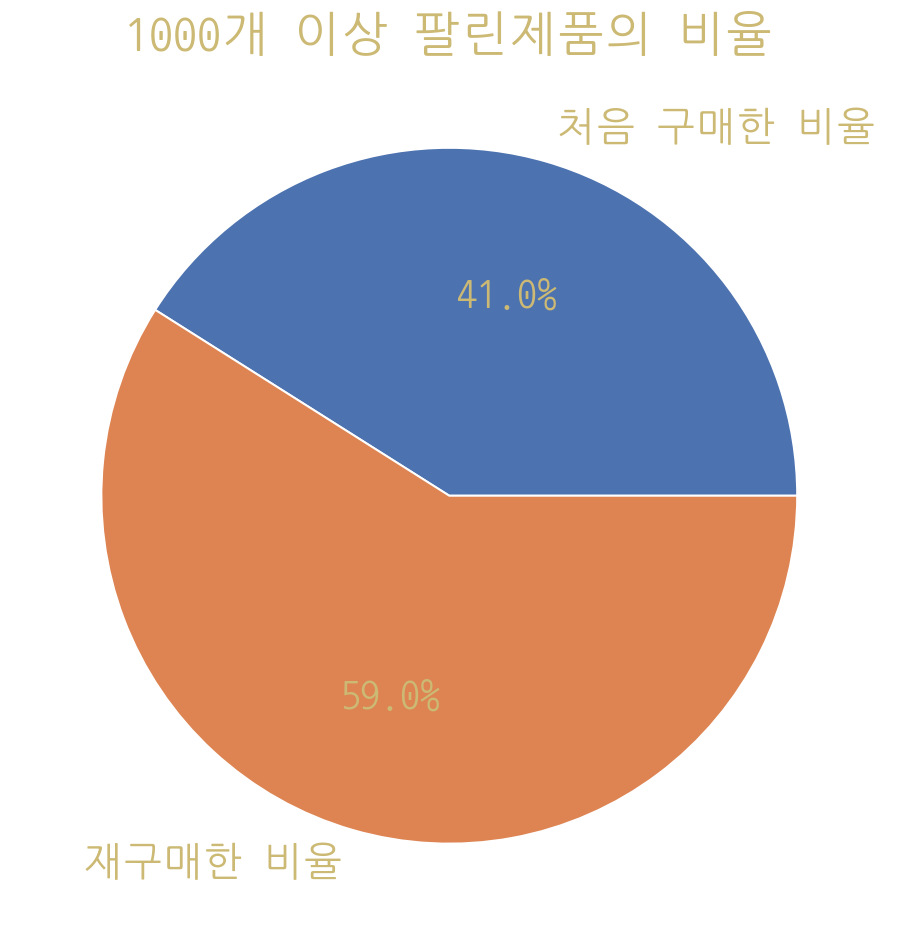

In [296]:
plt.figure(figsize=(24, 8))
plt.pie((A, B), labels=labels, autopct='%1.1f%%',textprops={'fontsize': 20, 'color' : 'y'})
plt.title('1000개 이상 팔린제품의 비율', fontsize = 24, color = 'y')
plt.show()

In [160]:
product_table = product_table[product_table['product_total'] >= 1000]
product_table.sort_values(by='product_name', ascending=True, inplace=True)

## 순위가 있는 데이터 이기때문에 스피어만 상관계수를 사용
- Spearman 상관은 두 계량형 변수 또는 순서형 변수 사이의 단순 관계를 평가

In [166]:
# 스피어만 상관계수
print("스피어만 상관계수", sp.stats.spearmanr(
   product_table['product_total'], product_table['product_reorder_rate'])[0])
# 피어슨 상관계수
print("피어슨 상관계수", np.corrcoef(
    product_table['product_total'], product_table['product_reorder_rate'])[0, 1])

스피어만 상관계수 0.24654252371746066
피어슨 상관계수 0.1791611470503542
스피어만 상관계수 SpearmanrResult(correlation=0.24654252371746066, pvalue=6.439651598668678e-71)


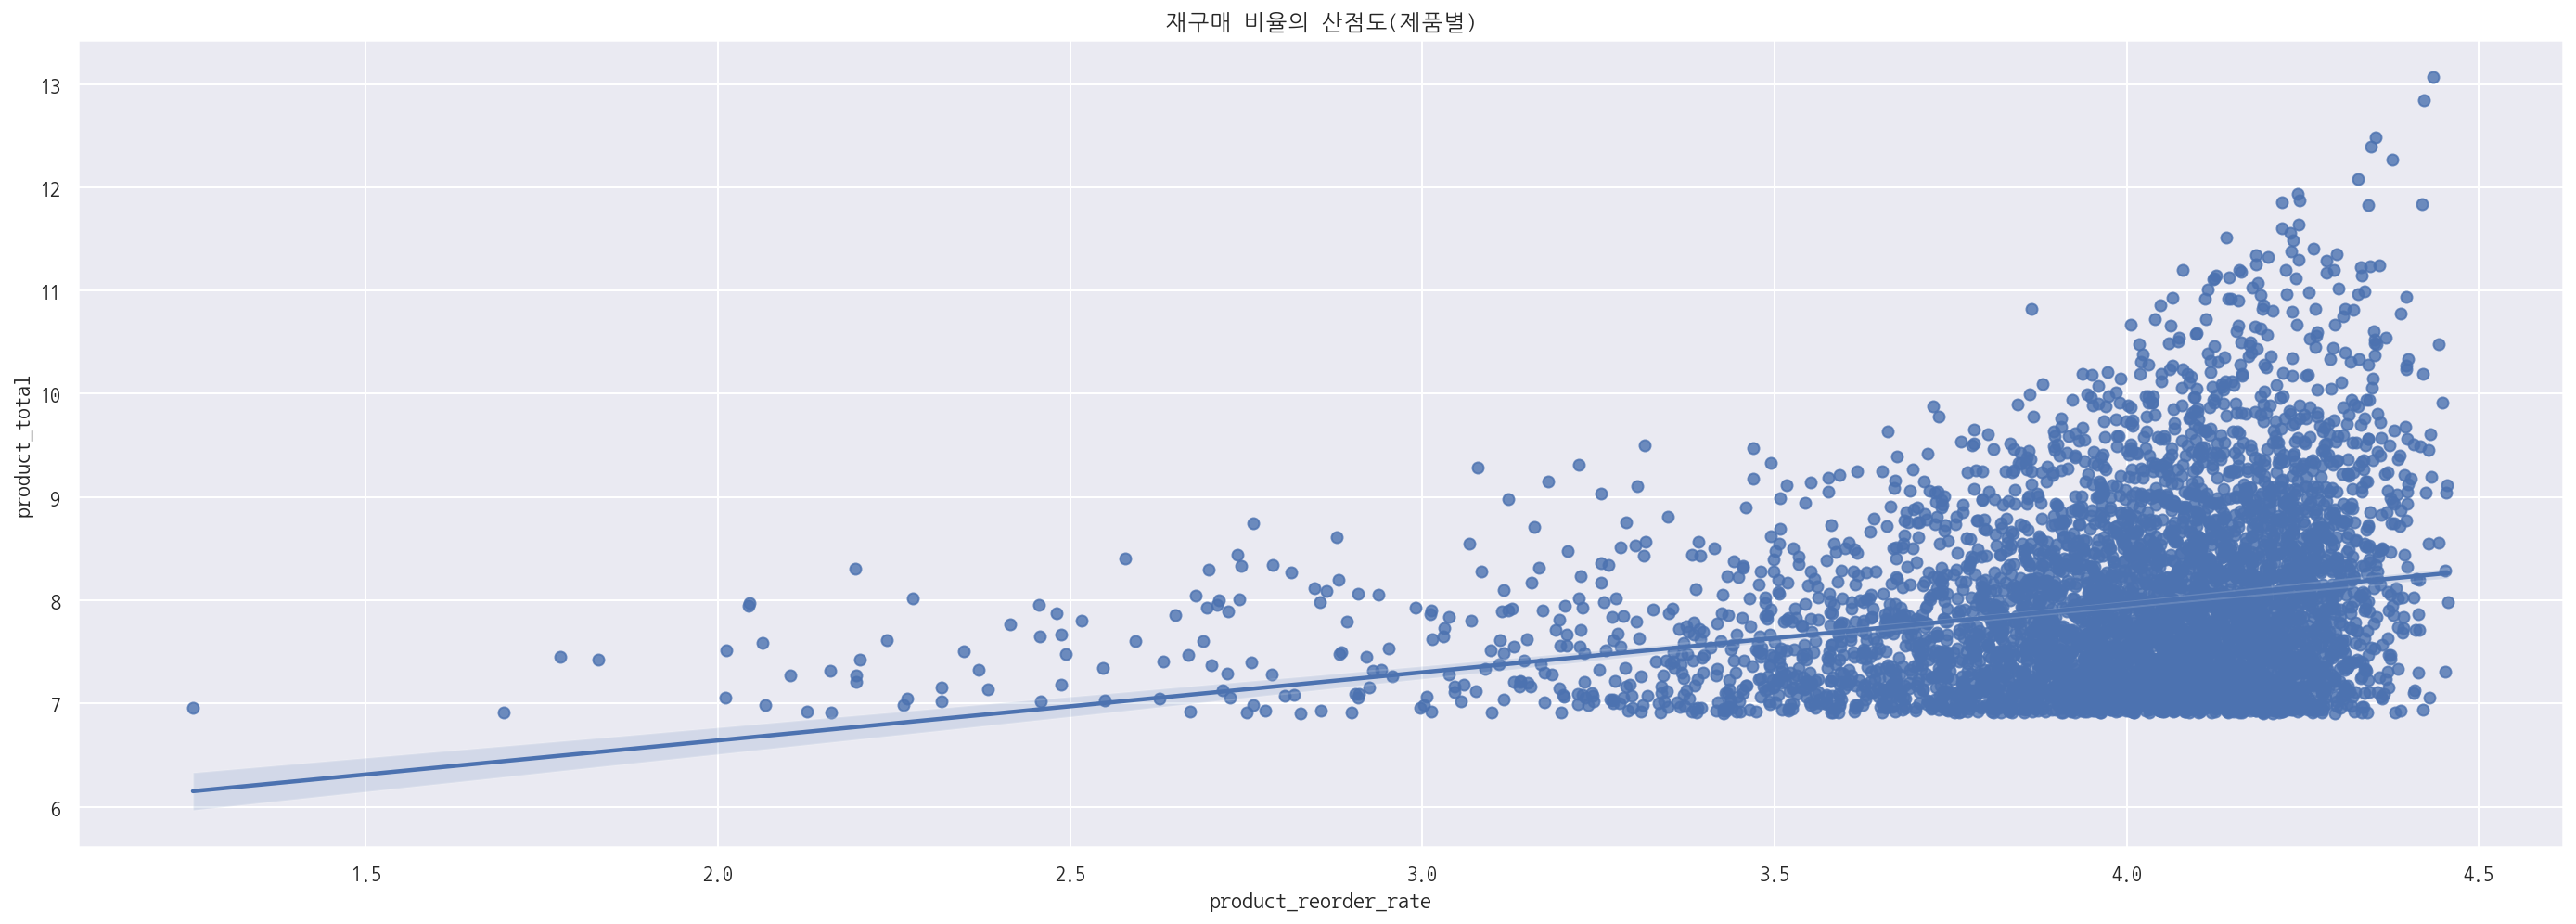

In [319]:
# 산점도
plt.figure(figsize=(24, 8))
sns.regplot(np.log(product_table['product_reorder_rate']),np.log(product_table['product_total']))
plt.title("재구매 비율의 산점도(제품별)")
plt.show()

## Aisle(제품의 소분류)별로 재구매율 확인해보기

In [120]:
# 분석용 데이터 프레임 생성
columns = ['aisle_id', 'reordered', 'aisle']
data_aisle = raw_data[columns]

# 피봇테이블 생성
aisle_table = data_aisle.pivot_table(
    index='aisle', columns='reordered', aggfunc='count')
columns = ['first_order', 'reorder']
aisle_table.columns = columns

# 피봇테이블 정리
aisle_table['aisle_total'] = aisle_table['first_order'] + \
    aisle_table['reorder']
aisle_table['aisle_reorder_rate'] = aisle_table['reorder'] / \
    aisle_table['aisle_total'] * 100
aisle_table.sort_values(by='aisle', ascending=False, inplace=True)
aisle_table.head()

,first_order,reorder,aisle_total,aisle_reorder_rate
aisle,,,,
yogurt,455325,997018,1452343,68.648935
white wines,11304,19254,30558,63.008050
water seltzer sparkling water,227556,613977,841533,72.959349
vitamins supplements,31023,14036,45059,31.150270
trash bags liners,21310,10771,32081,33.574390


In [121]:
# 스피어만 상관계수
print("스피어만 상관계수", sp.stats.spearmanr(
    aisle_table['aisle_total'], aisle_table['aisle_reorder_rate'])[0])
# 피어슨 상관계수
print("피어슨 상관계수", np.corrcoef(
    aisle_table['aisle_total'], aisle_table['aisle_reorder_rate'])[0, 1])

스피어만 상관계수 0.571525829499121
피어슨 상관계수 0.3806392220837948


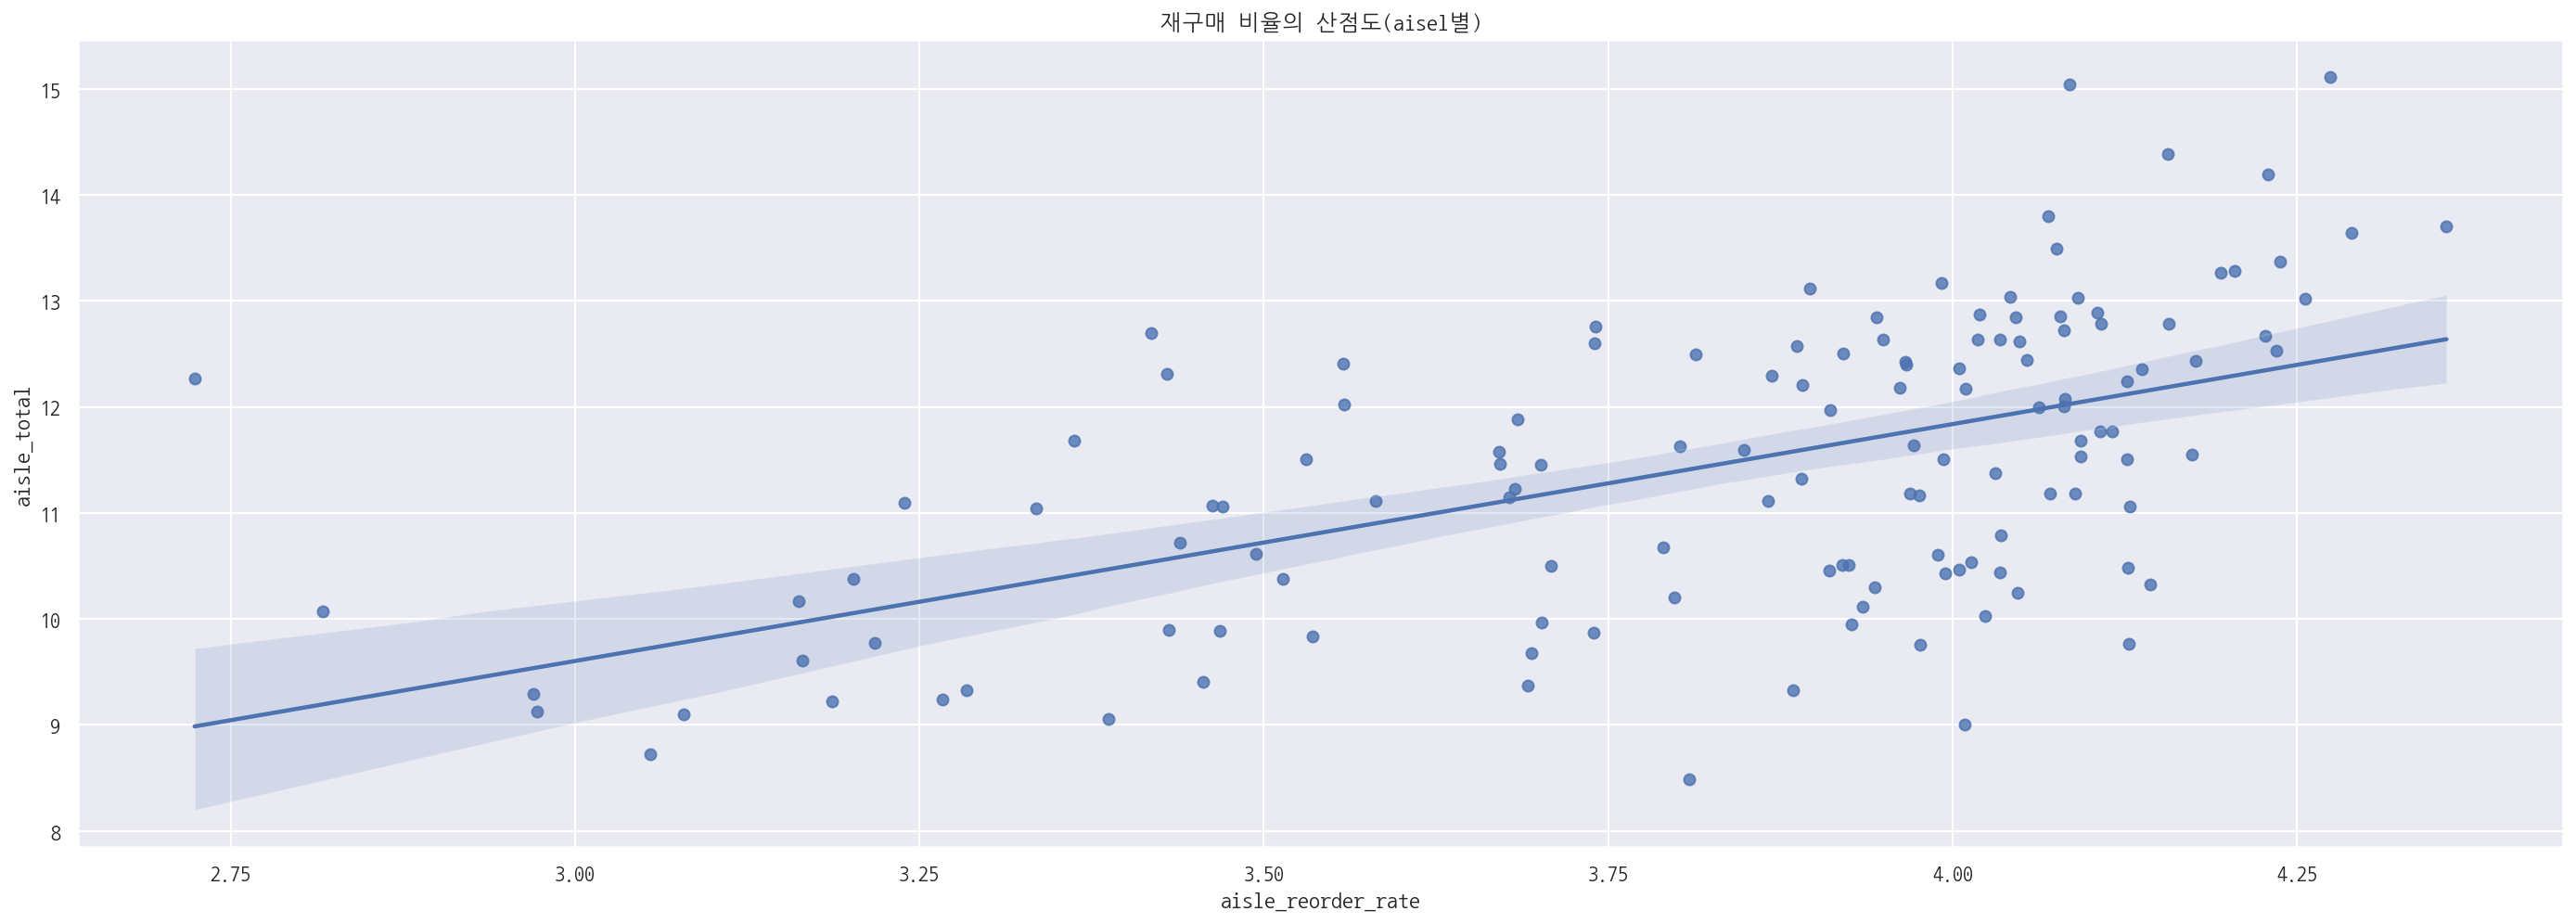

In [305]:
# 산점도
plt.figure(figsize=(24,8))
sns.regplot(np.log(aisle_table['aisle_reorder_rate']),np.log(aisle_table['aisle_total']))
plt.title("재구매 비율의 산점도(aisel별)")
plt.show()

## 가설 2 결론 : 
- ### 양의 상관계를 보이는것으로 보아, 주문량이 증가하면 재구매율도 같이 높다. 

## 가설 3 : 장바구니의 첫번째 담은 물건의 재구매의 확률이 높을 것이다.

In [171]:
# 분석용 데이터셋 생성
columns = ['order_id', 'product_id', 'add_to_cart_order',
           'reordered', 'days_since_prior_order']
data_cart = raw_data[columns]
data_cart.head(2)

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order
0,1107,1,7,0,7.0
1,1107,46149,6,0,7.0


In [172]:
# 총 주문갯수가 1개인 데이터의 갯수
a = data_cart['order_id'].value_counts() == 1
print(a.sum(), '개')

156748 개


In [173]:
# 전체 주문이 1인 데이터 갯수 전처리
# 전체 주문이 1인 데이터를 데이터 프레임 및 True = 1, False = 0 으로 변환
a = pd.DataFrame(a)
a.replace(False, 0, inplace=True)
# 컬럼명 변환
a.columns = ['first']
# merge용 index 생성
a.reset_index(inplace=True)

In [174]:
# 분석용 데이터 셋과, 전체 주문이 1개인 데이터 merge
data_cart_two_more = data_cart.merge(a, left_on='order_id', right_on='index')

In [175]:
# 전체 주문이 1개인 데이터 삭제
data_cart_two_more[data_cart_two_more['first'] != 1]

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order,index,first
0,1107,1,7,0,7.0,1107,0.0
1,1107,46149,6,0,7.0,1107,0.0
2,1107,9434,2,0,7.0,1107,0.0
3,1107,769,10,0,7.0,1107,0.0
4,1107,12078,9,0,7.0,1107,0.0
...,...,...,...,...,...,...,...
32434258,62363,5161,1,1,5.0,62363,0.0
32434265,1159533,1000,2,1,3.0,1159533,0.0
32434266,1159533,5161,1,1,3.0,1159533,0.0
32434275,3275452,1000,1,1,5.0,3275452,0.0


In [176]:
# 분석에 필요한 컬럼만 재 정렬
data_cart_two_more = data_cart_two_more[['order_id', 'product_id',
                                         'add_to_cart_order', 'reordered', 'days_since_prior_order']]

In [177]:
# 장바구니에 1번째로 담긴 품목만 확인
data_cart_two_more = data_cart_two_more[data_cart_two_more['add_to_cart_order'] == 1]
data_cart_two_more

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order
12,1107,16797,1,1,7.0
19,5319,19972,1,1,1.0
30,7540,48907,1,1,7.0
34,9228,45260,1,0,30.0
48,9273,38928,1,0,NaN
...,...,...,...,...,...
32434484,2235830,30365,1,0,6.0
32434485,2323735,30365,1,1,1.0
32434486,2733396,30365,1,0,0.0
32434487,31522,48778,1,1,4.0


## 각 주문에서 장바구니에 제일 처음 담은 물품만 남기고 필터링
## 3,346,083 (약 330만)

In [229]:
# 피벗테이블 생성
table_cart = data_cart_two_more.pivot_table(
    index='product_id', columns='reordered', values='add_to_cart_order', aggfunc='count', fill_value=0)
table_cart.reset_index(inplace=True)
table_cart.columns = ['product_id', 'first_order', 'reorder']
# proudct_name을 알기위해 df_ptoducts merge
table_cart_product = table_cart.merge(
    df_ptoducts, left_on='product_id', right_on='product_id')

In [230]:
# 피벗테이블의 컬럼명 정리
table_cart_product = table_cart_product[[
    'product_id', 'product_name', 'first_order', 'reorder']]
# 첫 주문과, 재주문의 총합 (1번째로 장바구니에 추가된 제품들의)
table_cart_product['total'] = table_cart_product['first_order'] + \
    table_cart_product['reorder']
# 1번째로 장바구니에 추가된 제품의 재구매 비율
table_cart_product['reorder_rate'] = table_cart_product['reorder'] / \
    table_cart_product['total'] * 100

## 장바구니에 처음 담긴 물품의 재구매율 상위 5위 비교

In [231]:
# 주문량이 많지 않음
table_cart_product.sort_values(by='reorder_rate', ascending=False).head()

,product_id,product_name,first_order,reorder,total,reorder_rate
35689,42419,Morning Oat Crunch Cinnamon Cereal,0,4,4,100.0
35685,42414,Little Champions Variety Pack Dog Food,0,5,5,100.0
19344,22980,BATAMPTE SAUERKRAUT 32 OZ R,0,1,1,100.0
9111,10843,Desiree Assortment of Wafers,0,1,1,100.0
30604,36327,Ice Cream Mexican Chili Chocolate,0,1,1,100.0


## 판매된 제품 수량별 재구매율

In [232]:
# 대표성 확인을 위한 함수 설정
def numofproduct(n):
    return table_cart_product[table_cart_product['total'] >= n].sort_values(by='reorder_rate', ascending=False)

In [233]:
# 100개 이상 팔린 제품의 reorder_rate
n = 100
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].count(), '가지 입니다.')
print(f'{n}개 이상 팔린 제품수의 총합은', numofproduct(n)['total'].sum(), '개 입니다.')
print('장바구니에 1번째로 선택된 제품의 총합은', table_cart_product['total'].sum(), '개 입니다.')
print(f'{n}개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의', round(numofproduct(n)[
      'total'].sum() / table_cart_product['total'].sum() * 100, 2), '% 입니다')

100개 이상 팔린 제품은 4540 가지 입니다.
100개 이상 팔린 제품수의 총합은 2662779 개 입니다.
장바구니에 1번째로 선택된 제품의 총합은 3214874 개 입니다.
100개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의 82.83 % 입니다


In [234]:
# 1000개 이상 팔린 제품의 reorder_rate
n = 1000
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].count(), '가지 입니다.')
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].sum(), '개 입니다.')
print('장바구니에 1번째로 선택된 제품의 총합은', table_cart_product['total'].sum(), '개 입니다.')
print(f'{n}개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의', round(numofproduct(n)[
      'total'].sum() / table_cart_product['total'].sum() * 100, 2), '% 입니다')

1000개 이상 팔린 제품은 463 가지 입니다.
1000개 이상 팔린 제품은 1529162 개 입니다.
장바구니에 1번째로 선택된 제품의 총합은 3214874 개 입니다.
1000개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의 47.57 % 입니다


In [235]:
# 10000개 이상 팔린 제품의 reorder_rate
n = 10000
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].count(), '가지 입니다.')
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].sum(), '개 입니다.')
print('장바구니에 1번째로 선택된 제품의 총합은', table_cart_product['total'].sum(), '개 입니다.')
print(f'{n}개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의', round(numofproduct(n)[
      'total'].sum() / table_cart_product['total'].sum() * 100, 2), '% 입니다')

10000개 이상 팔린 제품은 14 가지 입니다.
10000개 이상 팔린 제품은 416939 개 입니다.
장바구니에 1번째로 선택된 제품의 총합은 3214874 개 입니다.
10000개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의 12.97 % 입니다


In [258]:
numofproduct(1)

,product_id,product_name,first_order,reorder,total,reorder_rate
35689,42419,Morning Oat Crunch Cinnamon Cereal,0,4,4,100.0
35685,42414,Little Champions Variety Pack Dog Food,0,5,5,100.0
19344,22980,BATAMPTE SAUERKRAUT 32 OZ R,0,1,1,100.0
9111,10843,Desiree Assortment of Wafers,0,1,1,100.0
30604,36327,Ice Cream Mexican Chili Chocolate,0,1,1,100.0
...,...,...,...,...,...,...
5893,7011,Fusion Power Razor and Cartridge,2,0,2,0.0
5889,7007,Raw Organic Chia Seeds,4,0,4,0.0
27217,32340,Naturals Daily Clarifying Shampoo,3,0,3,0.0
5886,7002,"Chicken, Broccoli & Cheddar Frozen Sandwiches",1,0,1,0.0


In [246]:
numofproduct(100).head()

,product_id,product_name,first_order,reorder,total,reorder_rate
8432,10031,Homestyle Orange Juice,7,139,146,95.205479
6489,7733,Chardonnay California,10,126,136,92.647059
2710,3248,Breakfast Burrito With Potatoes Jack & Cheddar...,9,108,117,92.307692
14405,17163,Vitamin A & D Fat Free Milk,9,106,115,92.173913
29907,35496,Real2 Alkalized Water 500 ml,14,157,171,91.812865


In [247]:
numofproduct(1000).head(3)

,product_id,product_name,first_order,reorder,total,reorder_rate
38307,45504,Whole Organic Omega 3 Milk,213,2049,2262,90.583554
4643,5514,Organic Homogenized Whole Milk,119,1007,1126,89.431616
4614,5479,Italian Sparkling Mineral Water,732,5949,6681,89.043556


In [248]:
numofproduct(10000).head(3)

,product_id,product_name,first_order,reorder,total,reorder_rate
20924,24852,Banana,13023,97893,110916,88.258682
11061,13176,Bag of Organic Bananas,9947,69041,78988,87.406948
23445,27845,Organic Whole Milk,4187,26740,30927,86.461668


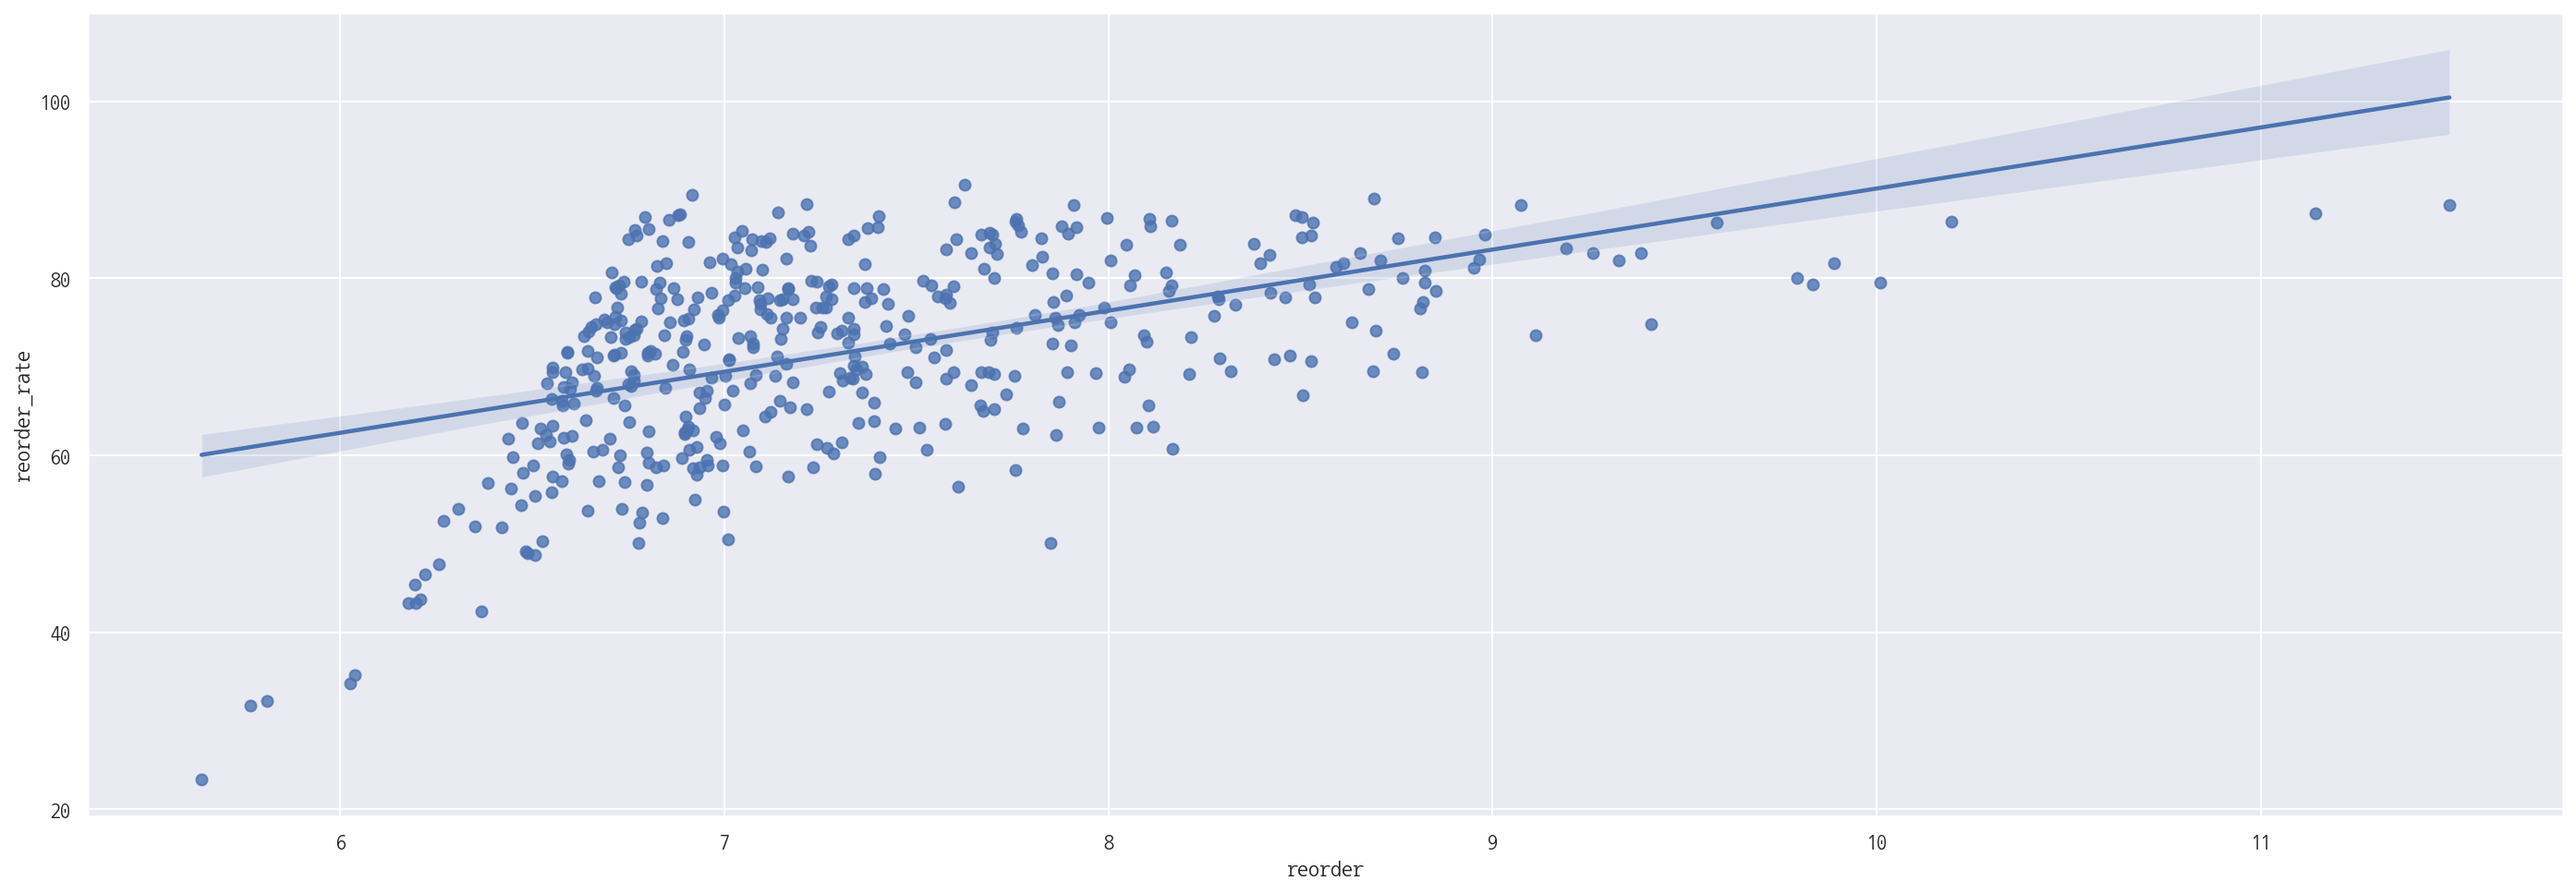

In [297]:
a = numofproduct(1000)
plt.figure(figsize=(24,8))
a.sort_values(by = 'reorder',ascending = False, inplace = True)
sns.regplot(np.log(a.reorder), a.reorder_rate)
plt.show()

## 가설 3 결론 : 장바구니에 첫번째로 들어간 제품은 재구매 한 재품일 확률이 높다.

## 가설 1 결론
- ### 요일, 시간별 구매횟수와 재구매 횟수는 비슷한 분포를 보인다.

## 가설 2 결론
- ### 양의 상관계를 보이는것으로 보아, 주문량이 증가하면 재구매율도 같이 높다. 

## 가설 3 결론
- ### 장바구니에 첫번째로 들어간 제품은 재구매 한 재품일 확률이 높다.

# 그래서 이용자들은 어떤 물건을 재구매할 확률이 높은 걸까?


### 재구매율은 시간 및 요일보다, 제품의 주문량이 높고, 장바구니에 첫번째로 들어간 제품일수록 높아진다.

## So what?
> **사업이 발전하려면, 재구매율을 높여야 한다.**

> **이를 위해, 주문량이 높고, 장바구니에 처음들어간 제품을 우선으로 프로모션하고,
유사한 제품을 취급하는 채널들과의 연계를 발전시켜야 한다.**

# 그리고...

- #### 처음 구매한 주문이 약 40%를 차지 한다는건, 취급하는 상점이 증가되거나, 신규유저가 지속적으로 유입되서 새로운 주문이 증가했다고 볼수 있다.
- #### 즉 이 데이터셋이 수집된 기간 동안 사업이 지속적으로 성장했다고도 볼수 있다.


In [24]:
# 처음 구매한 비율
1 - (raw_data["reordered"].sum() / len(raw_data["reordered"]))

0.4099382757190566

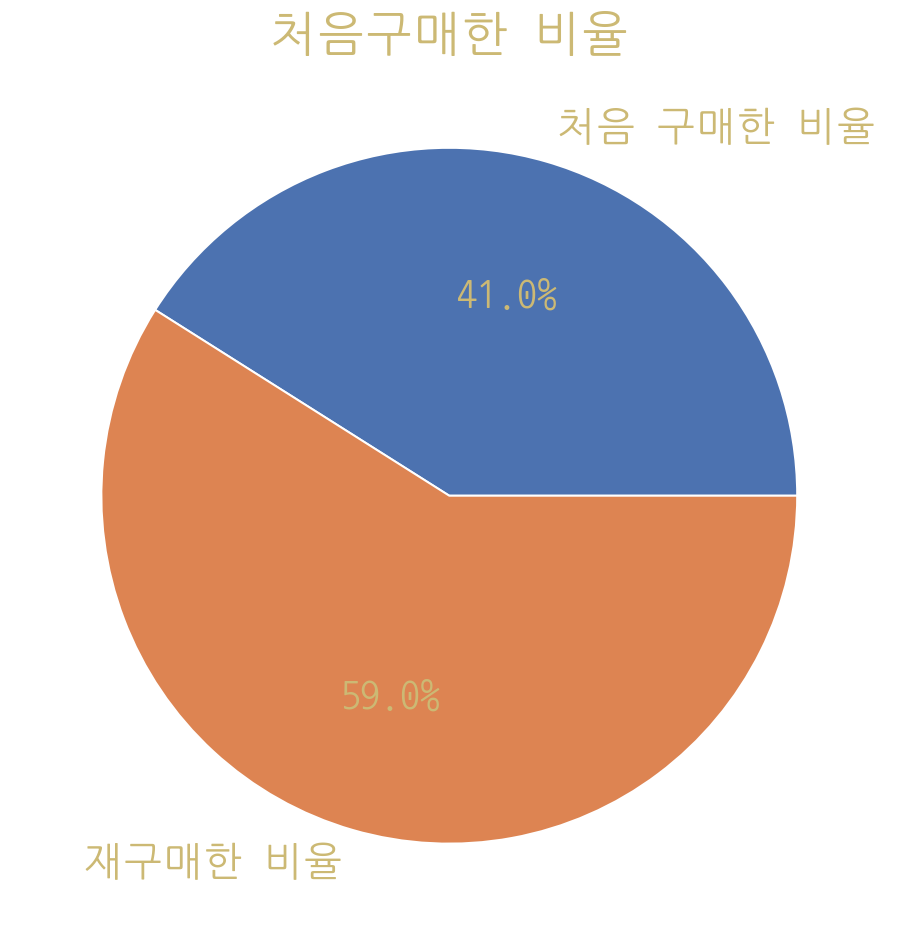

In [295]:
A = 1 - (raw_data["reordered"].sum() / len(raw_data["reordered"]))
B = (raw_data["reordered"].sum() / len(raw_data["reordered"]))
labels = ['처음 구매한 비율', '재구매한 비율']
plt.figure(figsize=(24, 8))
plt.pie((A, B), labels=labels, autopct='%1.1f%%',textprops={'fontsize': 20, 'color' : 'Y'})
plt.title('처음구매한 비율', fontsize = 24, color = 'Y')
plt.show()

# 아쉬운점

- #### 예측 모델을 만들어 봤으면..
- #### barplot 같은 좀더 직관적인 그래프 였으면..
- #### 날짜 데이터가 있었다면..